#  Home assignment #2. Particle filter

In this homework assignment, we will implement an algorithm for estimating the robot's pose known as a particle filter.
A particle filter consists of the following steps:
1. The movement of particles in accordance with the kinematic motion model. The movement is carried out using the probabilistic motion function, taking into account the randomness of the process (noise of the motion).
2. Comparison of the obtained measurement with the expected one by applying a probabilistic measurement function that estimates the probability of the obtained measurement given a fixed position of the particle. As a result of this step, each particle is assigned a weight proportional to the likelihood of the measurement given the position of the particle.
3. Resampling is a process in which the probability of a particle to be chosen for a new set is proportional to the weight (likelihood) of the particle.


## Task 1
 
Implement the motion model of the mobile robot $ p (x_ {t + 1} | x_t, u_t) $ as part of the *Robot* class. The method must be named *move()*. The *move()* method takes as input the current position of the robot and a vector of control signals (the steering angle ($ \alpha $) and the distance the robot should move ($ d $)). The *move()* method must return an instance of the *Robot* class with a new state vector $ (x, y, \theta) $.

For this homework assignment, we will assume that our robot has car-like kinematics. Such kinematics is described by the [bicycle model] (https://nabinsharma.wordpress.com/2014/01/02/kinematics-of-a-robot-bicycle-model/) (you can also refer to Lecture 3. The tricycle (note the difference in the notation). You need to implement a bicycle model in the *move()* method as an approximation of car-like kinematics.

**Important:** The coordinates $ (x, y) $ of the robot's state vector set the position of the center of the rear wheel axle of the robot.

**Important:** The *move()* method must also simulate the noise of the control signals. For this, additive normal noise is applied to each component of the control signal vector. The steering angle noise is specified by the *Robot.steering_noise* class attribute. The movement noise is specified by the *Robot.distance_noise* class attribute. The *Robot.steering_noise* and *Robot.distance_noise* parameters set the standard deviation ($ \sigma $) of the normal distribution.

In [28]:
from math import *
import random
import numpy as np


In [29]:
# --------
# 
# the "world" has 4 landmarks.
# the robot's initial coordinates are somewhere in the square
# represented by the landmarks.

landmarks  = [[100.0, 0.0], [0.0, 0.0], [0.0, 100.0], [100.0, 100.0]] # position of 4 landmarks
world_size = 100.0 # world is NOT cyclic. Robot is allowed to travel "out of bounds"

In [32]:
class Robot:

    # --------

    # init: 
    #   creates robot and initializes location/orientation 
    #

    def __init__(self, length = 10.0):
        self.x = random.random() * world_size # initial x position
        self.y = random.random() * world_size # initial y position
        self.orientation = random.random() * 2.0 * pi # initial orientation
        self.length = length # length of robot
        self.bearing_noise  = 0.0 # initialize bearing noise to zero
        self.distance_noise = 0.0 # initialize distance noise to zero
        self.steering_noise = 0.0 # initialize steering noise to zero

    
    def __repr__(self):
        return '[x=%.6s y=%.6s theta=%.6s]' % (str(self.x), str(self.y), str(self.orientation))
    # --------
    # set: 
    #   sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):


        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_b_noise, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.bearing_noise  = float(new_b_noise)
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)
    
    ############# ONLY ADD/MODIFY CODE BELOW ###################

    # --------
    # move:
    #   move along a section of a circular path according to motion parameters
    #
    
    def move(self, motion):
 
       alpha = motion[0] + random.gauss(0.0, self.steering_noise)
       d = motion[1] + random.gauss(0.0, self.distance_noise)

       
       if alpha != 0: 
         R = self.length / tan(alpha)
         B = d / R
         theta_t = (self.orientation + B ) % (2*pi) 
         x_c =  self.x - R*sin(self.orientation)
         y_c = self.y  + R*cos(self.orientation)
         x_t = x_c + R*sin(self.orientation + B  ) 
         y_t = y_c - R*cos(self.orientation + B  )
       else:
         theta_t = (self.orientation)      
         x_t = self.x + d*cos(self.orientation  ) 
         y_t = self.y + d*sin(self.orientation  )

       myrobot = Robot(self.length)
       myrobot.set(x_t, y_t, theta_t)
       myrobot.set_noise(self.bearing_noise, self.steering_noise, self.distance_noise)
       return myrobot

       


         # make sure your move function returns an instance of Robot class
         # with the correct coordinates.
 
    ############## ONLY ADD/MODIFY CODE ABOVE ####################

In [33]:
## --------
## TEST CASE #1:
## 
## The following code should print:
##       Robot:     [x=0.0 y=0.0 theta=0.0]
##       Robot:     [x=10.0 y=0.0 theta=0.0]
##       Robot:     [x=19.861 y=1.4333 theta=0.2886]
##       Robot:     [x=39.034 y=7.1270 theta=0.2886]
##

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(0.0, 0.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

motions = [[0.0, 10.0], [pi / 6.0, 10], [0.0, 20.0]]

T = len(motions)

print('Robot:    ', myrobot)
for t in range(T):
    myrobot = myrobot.move(motions[t])
    print('Robot:    ', myrobot)

Robot:     [x=0.0 y=0.0 theta=0.0]
Robot:     [x=10.0 y=0.0 theta=0.0]
Robot:     [x=19.861 y=1.4333 theta=0.2886]
Robot:     [x=39.034 y=7.1270 theta=0.2886]


In [34]:
## --------
## TEST CASE #2:
## 
## The following code should print:
##      Robot:     [x=0.0 y=0.0 theta=0.0]
##      Robot:     [x=9.9828 y=0.5063 theta=0.1013]
##      Robot:     [x=19.863 y=2.0201 theta=0.2027]
##      Robot:     [x=29.539 y=4.5259 theta=0.3040]
##      Robot:     [x=38.913 y=7.9979 theta=0.4054]
##      Robot:     [x=47.887 y=12.400 theta=0.5067]
##      Robot:     [x=56.369 y=17.688 theta=0.6081]
##      Robot:     [x=64.273 y=23.807 theta=0.7094]
##      Robot:     [x=71.517 y=30.695 theta=0.8108]
##      Robot:     [x=78.027 y=38.280 theta=0.9121]
##      Robot:     [x=83.736 y=46.485 theta=1.0135]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(0.0, 0.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

motions = [[0.2, 10.] for row in range(10)]

T = len(motions)

print('Robot:    ', myrobot)
for t in range(T):
    myrobot = myrobot.move(motions[t])
    print('Robot:    ', myrobot) 

Robot:     [x=0.0 y=0.0 theta=0.0]
Robot:     [x=9.9828 y=0.5063 theta=0.1013]
Robot:     [x=19.863 y=2.0201 theta=0.2027]
Robot:     [x=29.539 y=4.5259 theta=0.3040]
Robot:     [x=38.913 y=7.9979 theta=0.4054]
Robot:     [x=47.887 y=12.400 theta=0.5067]
Robot:     [x=56.369 y=17.688 theta=0.6081]
Robot:     [x=64.273 y=23.807 theta=0.7094]
Robot:     [x=71.517 y=30.695 theta=0.8108]
Robot:     [x=78.027 y=38.280 theta=0.9121]
Robot:     [x=83.736 y=46.485 theta=1.0135]


## Task 2
 
Implement a mobile robot measurement method. The method must be named *sense()*. The *sense()* method takes as input the current state of the robot (*self*) and returns $ z $ - the current measurement consisting of four bearings to four landmarks located in space. Bearing is the angle at which the object is observed from the current position. The angle at which the robot observes each landmark is measured from the robot's current orientation $ \theta $. The counterclockwise direction is assumed to be positive.

To calculate the bearing, you need the position of the landmarks in space. It is set by the global variable *landmarks*.

**Important:** The *sense()* method should also simulate the measurement noise. For this, additive normal noise is applied to each component of the measurement vector. The measurement noise is specified by the *Robot.bearing_noise* class attribute. This parameter specifies the standard deviation ($ \sigma $) of the normal distribution. Provide the ability to calculate a noisy measurement vector by passing an input argument *no_noise = True* to the function.

Copy the *Robot* class to the cell below and add the *sense()* method to it.

In [36]:
class Robot:

    # --------

    # init: 
    #   creates robot and initializes location/orientation 
    #

    def __init__(self, length = 10.0):
        self.x = random.random() * world_size # initial x position
        self.y = random.random() * world_size # initial y position
        self.orientation = random.random() * 2.0 * pi # initial orientation
        self.length = length # length of robot
        self.bearing_noise  = 0.0 # initialize bearing noise to zero
        self.distance_noise = 0.0 # initialize distance noise to zero
        self.steering_noise = 0.0 # initialize steering noise to zero

    
    def __repr__(self):
        return '[x=%.6s y=%.6s theta=%.6s]' % (str(self.x), str(self.y), str(self.orientation))
    # --------
    # set: 
    #   sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):


        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_b_noise, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.bearing_noise  = float(new_b_noise)
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)
    
    ############# ONLY ADD/MODIFY CODE BELOW ###################

    # --------
    # move:
    #   move along a section of a circular path according to motion parameters
    #
    
    def move(self, motion):
 
       alpha = motion[0] + random.gauss(0.0, self.steering_noise)
       d = motion[1] + random.gauss(0.0, self.distance_noise)

       
       if alpha != 0: 
         R = self.length / tan(alpha)
         B = d / R
         theta_t = (self.orientation + B ) % (2*pi) 
         x_c =  self.x - R*sin(self.orientation)
         y_c = self.y  + R*cos(self.orientation)
         x_t = x_c + R*sin(self.orientation + B  ) 
         y_t = y_c - R*cos(self.orientation + B  )
       else:
         theta_t = (self.orientation)      
         x_t = self.x + d*cos(self.orientation  ) 
         y_t = self.y + d*sin(self.orientation  )

       myrobot = Robot(self.length)
       myrobot.set(x_t, y_t, theta_t)
       myrobot.set_noise(self.bearing_noise, self.steering_noise, self.distance_noise)
       return myrobot

     

         # make sure your move function returns an instance of Robot class
         # with the correct coordinates.
 
    ############## ONLY ADD/MODIFY CODE ABOVE ####################

    def sense(self, no_noise = False):
      if  no_noise :
        s_b = 0
      else:
        #s_b = np.random.normal(loc=0.0,scale=self.bearing_noise)
        s_b = random.gauss(0.0, self.bearing_noise)

      #print(no_noise)
      alpha = []
      for land in landmarks:
        temp5 = atan2(land[1] - self.y, land[0] - self.x) - self.orientation + s_b 
        
        if temp5 < 0:
          temp5 = 2*pi + temp5
        


        
        alpha.append(temp5)

      return alpha



      

In [37]:
## --------
## TEST CASE #1:
## 
## 1) The following code should print the list:
## [6.004885648174475, 3.7295952571373605, 1.9295669970654687, 0.8519663271732721]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(30.0, 20.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

print('Robot:        ', myrobot) 
print('Measurements: ', myrobot.sense()) 

Robot:         [x=30.0 y=20.0 theta=0.0]
Measurements:  [6.004885648174475, 3.7295952571373605, 1.9295669970654687, 0.8519663271732721]


In [38]:
## --------
## TEST CASE #2:
## 
## 2) The following code should print the list^
## [5.376567117456516, 3.101276726419402, 1.3012484663475101, 0.22364779645531352]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(30.0, 20.0, pi / 5.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

print('Robot:        ', myrobot) 
print('Measurements: ', myrobot.sense()) 

Robot:         [x=30.0 y=20.0 theta=0.6283]
Measurements:  [5.376567117456516, 3.101276726419402, 1.3012484663475101, 0.22364779645531352]


## Task 3

Implement the mobile robot observation model $ p (z_t | x_t, M) $. The method must be named *measurement_prob()*. The *measurement_prob()* method takes a measurement vector $ z $ as input and returns the likelihood of the measurement. Likelihood is calculated as the product of four (by the number of landmarks) normal distributions of measurement errors. Each normal distribution shows the bearing probability i.e. the normal distribution of the error for each bearing has the mathematical expectation in the true (expected) bearing value and the variance given by the *Robot.bearing_noise* parameter.

**Important:** Remember to normalize the angles when calculating bearing errors. The error must be in the range $ - \pi ... + \pi $.

**Important:** To get the true (expected) values of the measurements, you can use the *sense()* method with the *no_noise = True* flag.

Copy the *Robot* class into the cell below and add the *measurement_prob()* method to it.

In [39]:
class Robot:

    # --------

    # init: 
    #   creates robot and initializes location/orientation 
    #

    def __init__(self, length = 10.0):
        self.x = random.random() * world_size # initial x position
        self.y = random.random() * world_size # initial y position
        self.orientation = random.random() * 2.0 * pi # initial orientation
        self.length = length # length of robot
        self.bearing_noise  = 0.0 # initialize bearing noise to zero
        self.distance_noise = 0.0 # initialize distance noise to zero
        self.steering_noise = 0.0 # initialize steering noise to zero

    
    def __repr__(self):
        return '[x=%.6s y=%.6s theta=%.6s]' % (str(self.x), str(self.y), str(self.orientation))
    # --------
    # set: 
    #   sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):


        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_b_noise, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.bearing_noise  = float(new_b_noise)
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)
    
    ############# ONLY ADD/MODIFY CODE BELOW ###################

    # --------
    # move:
    #   move along a section of a circular path according to motion parameters
    #
    
    def move(self, motion):
 
       alpha = motion[0] + random.gauss(0.0, self.steering_noise)
       d = motion[1] + random.gauss(0.0, self.distance_noise)

       
       if alpha != 0: 
         R = self.length / tan(alpha)
         B = d / R
         theta_t = (self.orientation + B ) % (2*pi) 
         x_c =  self.x - R*sin(self.orientation)
         y_c = self.y  + R*cos(self.orientation)
         x_t = x_c + R*sin(self.orientation + B  ) 
         y_t = y_c - R*cos(self.orientation + B  )
       else:
         theta_t = (self.orientation)      
         x_t = self.x + d*cos(self.orientation  ) 
         y_t = self.y + d*sin(self.orientation  )

       myrobot = Robot(self.length)
       myrobot.set(x_t, y_t, theta_t)
       myrobot.set_noise(self.bearing_noise, self.steering_noise, self.distance_noise)
       return myrobot

       


         # make sure your move function returns an instance of Robot class
         # with the correct coordinates.
 
    ############## ONLY ADD/MODIFY CODE ABOVE ####################

    def sense(self, no_noise = False):
      if  no_noise :
        s_b = 0
      else:
        #s_b = np.random.normal(loc=0.0,scale=self.bearing_noise)
        s_b = random.gauss(0.0, self.bearing_noise)
     
      alpha = []
      for land in landmarks:
        temp5 = atan2(land[1] - self.y, land[0] - self.x) - self.orientation + s_b
         
        if temp5 < 0:
          temp5 = 2*pi + temp5
       
        
        alpha.append(temp5)

      return alpha
 

    
    def measurement_prob(self, vector_z):
       result_prob = 1.0
       Z = self.sense(no_noise = True)
       error_b = [x1 - x2 for (x1, x2) in zip(Z ,vector_z)]
       i = 0
       for e_b in error_b:
         
         while e_b > pi:
           e_b -=  2*pi
         while e_b < -pi:
           e_b +=  2*pi         
         
         variance = self.bearing_noise
         r =  vector_z[i]  
              
         result_prob *= exp(- ((e_b) ** 2) / (2.0 * variance )) / sqrt(2.0 * pi * variance )
         i+=1

       return result_prob







      

## Task 4

Run the particle filter based on the *Robot* class you have implemented. Add a step-by-step visualization of the particle filter for the second test case. The visualization should reflect:
1. Map with marked positions of landmarks.
2. Particles - it is enough to reflect only $ (x, y) $.
3. The final estimated position of the robot at each moment in time.

In [40]:
from math import *
import random

max_steering_angle = pi / 4.0 # You do not need to use this value, but keep in mind the limitations of a real car.
bearing_noise = 0.1 
steering_noise = 0.1
distance_noise = 5.0

tolerance_xy = 15.0 # Tolerance for localization in the x and y directions.
tolerance_orientation = 0.25 # Tolerance for orientation.


# --------
# 
# the "world" has 4 landmarks.
# the robot's initial coordinates are somewhere in the square
# represented by the landmarks.

landmarks  = [[100.0, 0.0], [0.0, 0.0], [0.0, 100.0], [100.0, 100.0]] # position of 4 landmarks
world_size = 100.0 # world is NOT cyclic. Robot is allowed to travel "out of bounds"

In [41]:
# Some utility functions

def get_position(p):
    x = 0.0
    y = 0.0
    orientation = 0.0
    for i in range(len(p)):
        x += p[i].x
        y += p[i].y
        # orientation is tricky because it is cyclic. By normalizing
        # around the first particle we are somewhat more robust to
        # the 0=2pi problem
        orientation += (((p[i].orientation - p[0].orientation + pi) % (2.0 * pi)) 
                        + p[0].orientation - pi)
    return [x / len(p), y / len(p), orientation / len(p)]


# The following code generates ground truth poses and measurements
def generate_ground_truth(motions):

    myrobot = Robot()
    myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

    Z = []
    T = len(motions)

    for t in range(T):
        myrobot = myrobot.move(motions[t])
        Z.append(myrobot.sense())
    #print 'Robot:    ', myrobot
    return [myrobot, Z]


# The following code prints the measurements associated
# with generate_ground_truth
def print_measurements(Z):

    T = len(Z)

    print('measurements = [[%.8s, %.8s, %.8s, %.8s],' % \
        (str(Z[0][0]), str(Z[0][1]), str(Z[0][2]), str(Z[0][3])))
    for t in range(1,T-1):
        print('                [%.8s, %.8s, %.8s, %.8s],' % \
            (str(Z[t][0]), str(Z[t][1]), str(Z[t][2]), str(Z[t][3])))
    print('                [%.8s, %.8s, %.8s, %.8s]]' % \
        (str(Z[T-1][0]), str(Z[T-1][1]), str(Z[T-1][2]), str(Z[T-1][3])))


# The following code checks to see if your particle filter
# localizes the robot to within the desired tolerances
# of the true position. The tolerances are defined at the top.
def check_output(final_robot, estimated_position):

    error_x = abs(final_robot.x - estimated_position[0])
    error_y = abs(final_robot.y - estimated_position[1])
    error_orientation = abs(final_robot.orientation - estimated_position[2])
    error_orientation = (error_orientation + pi) % (2.0 * pi) - pi
    correct = error_x < tolerance_xy and error_y < tolerance_xy \
              and error_orientation < tolerance_orientation
    return correct

def viualization(particles, estimated_position):
    import matplotlib.pyplot as plt
    plt.figure("Robot in the world", figsize=(15., 15.))

    grid = [-world_size, world_size, -world_size, world_size]
    plt.axis(grid)
    plt.grid(b=True, which='major', color='0.75', linestyle='--')
    plt.xticks([i for i in range(0, 220, 20)])
    plt.yticks([i for i in range(0, 220,20)])
    for lm in landmarks:
        circle = plt.Circle((lm[0], lm[1]), 1., facecolor='#cc0000', edgecolor='#330000')
        plt.gca().add_patch(circle)
        
    for i in range(0,len(particles)):            
        circle = plt.Circle((particles[i].x, particles[i].y), 3, facecolor='#0000ff', edgecolor='#000000')
        plt.gca().add_patch(circle)
       
    circle = plt.Circle((estimated_position[0], estimated_position[1]), 2, facecolor='#ffff00', edgecolor='#000000')
    plt.gca().add_patch(circle) 
    
      
    
    
    plt.show()


In [42]:
def particle_filter(motions, measurements, N=500): # We will use 500 particles
    # --------
    #
    # Make particles
    # 
    pr =[]
    particles = []
    for i in range(N):
        r = Robot()
        r.set_noise(bearing_noise, steering_noise, distance_noise)
        particles.append(r)

    # --------
    #
    # Update particles
    #     

    for t in range(len(motions)):
        pr =[]
        # motion update (prediction)
        particles_after_motion = []
        for i in range(N):
            particles_after_motion.append(particles[i].move(motions[t]))
        pr = particles_after_motion.copy()
        particles = particles_after_motion

        # measurement update (correction)
        weights = []
        for i in range(N):
            weights.append(particles[i].measurement_prob(measurements[t]))

        # resampling
        particles_resampled = []
        index = int(random.random() * N)
        beta = 0.0
        mw = max(weights)
        for i in range(N):
            beta += random.random() * 2.0 * mw
            while beta > weights[index]:
                beta -= weights[index]
                index = (index + 1) % N
            particles_resampled.append(particles[index])
        
        particles = particles_resampled
        viualization(pr, get_position(particles))
    
    return get_position(particles)

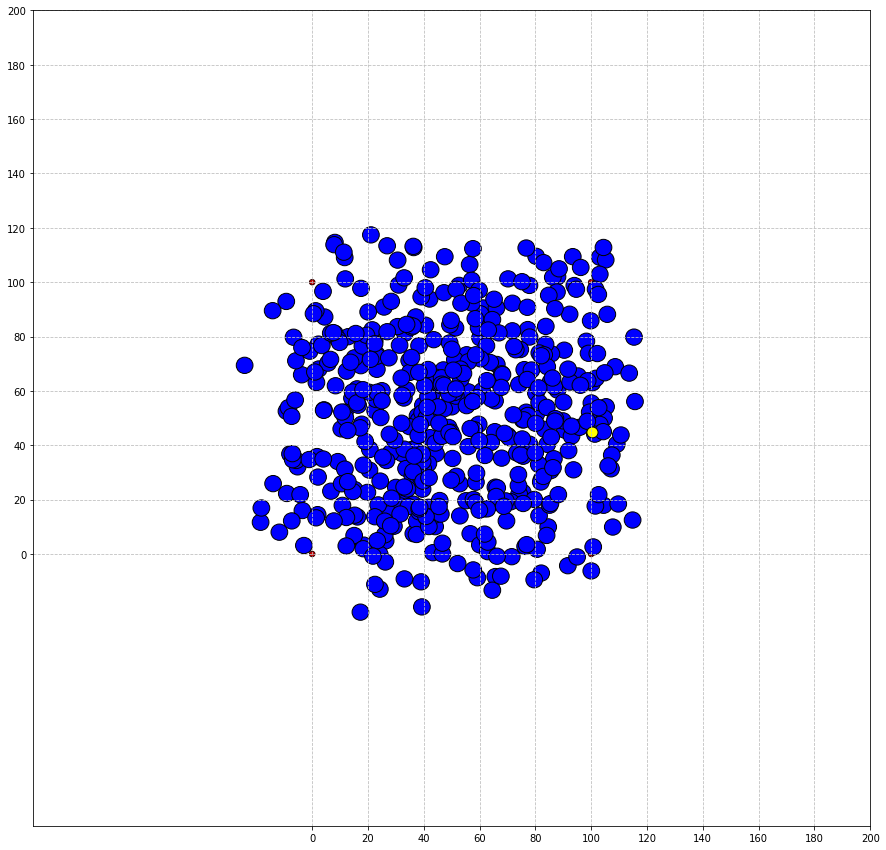

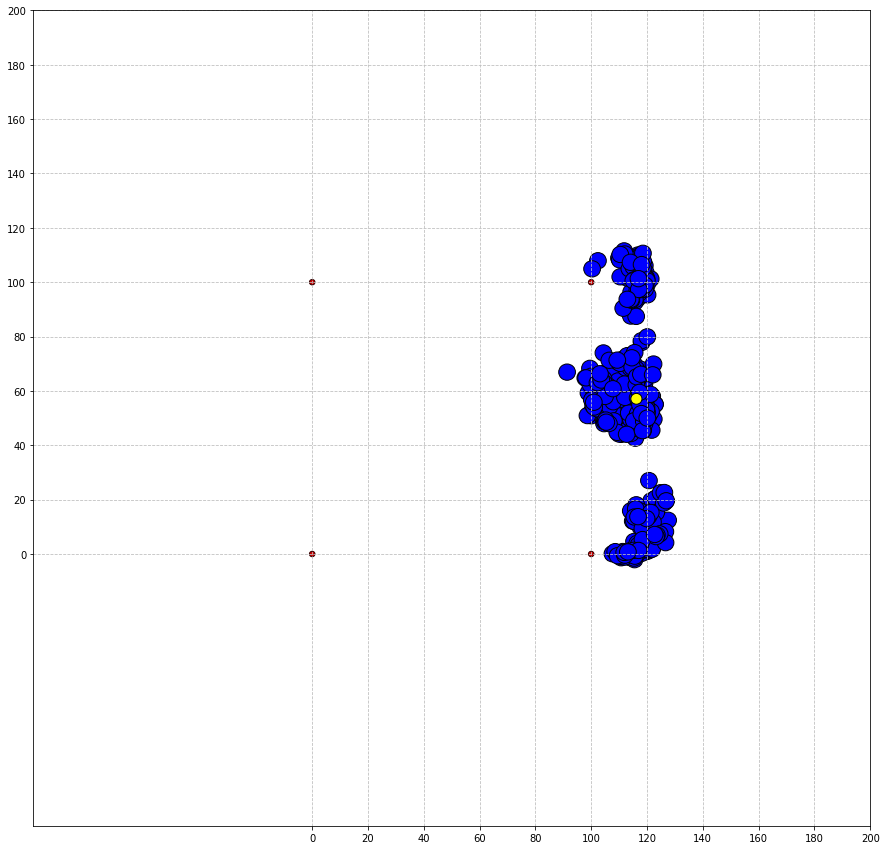

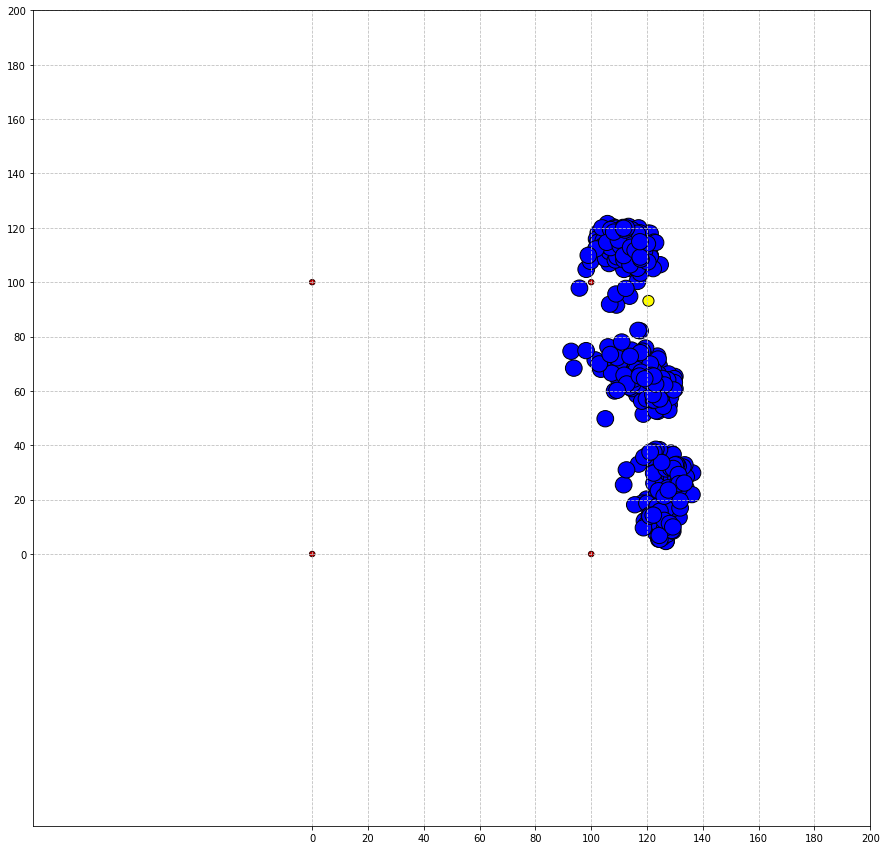

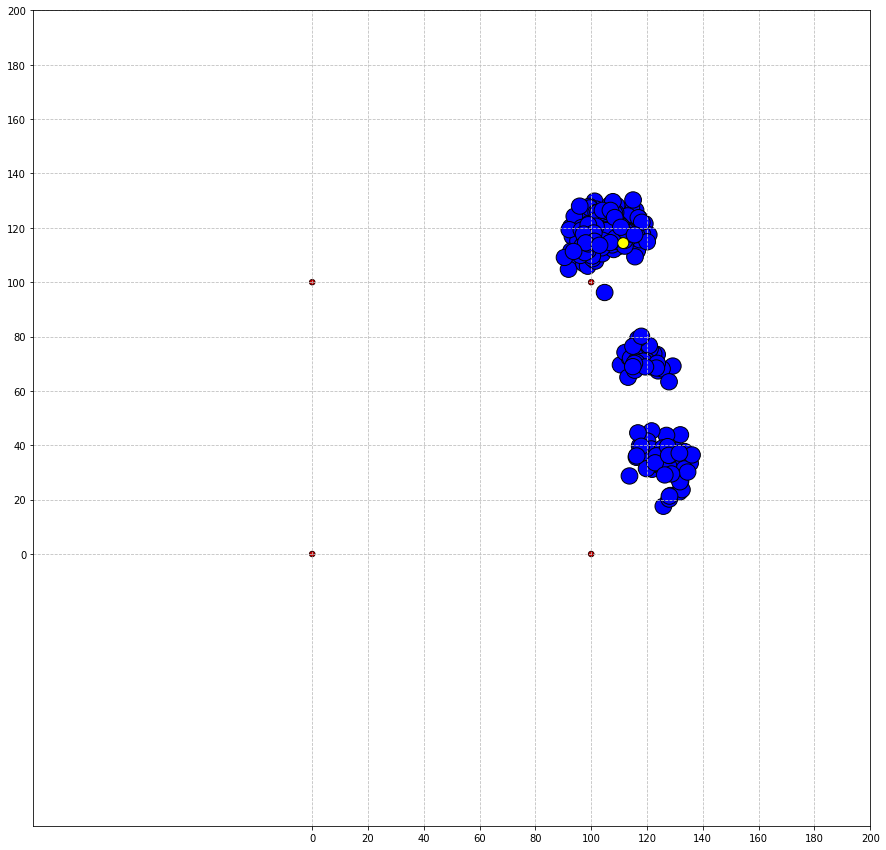

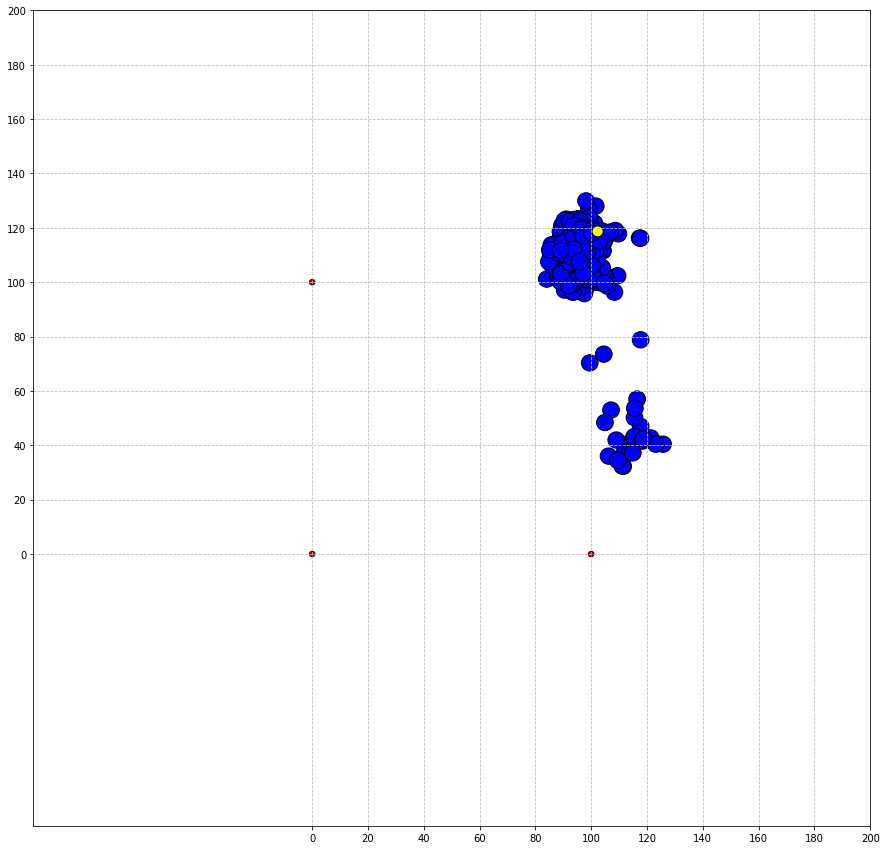

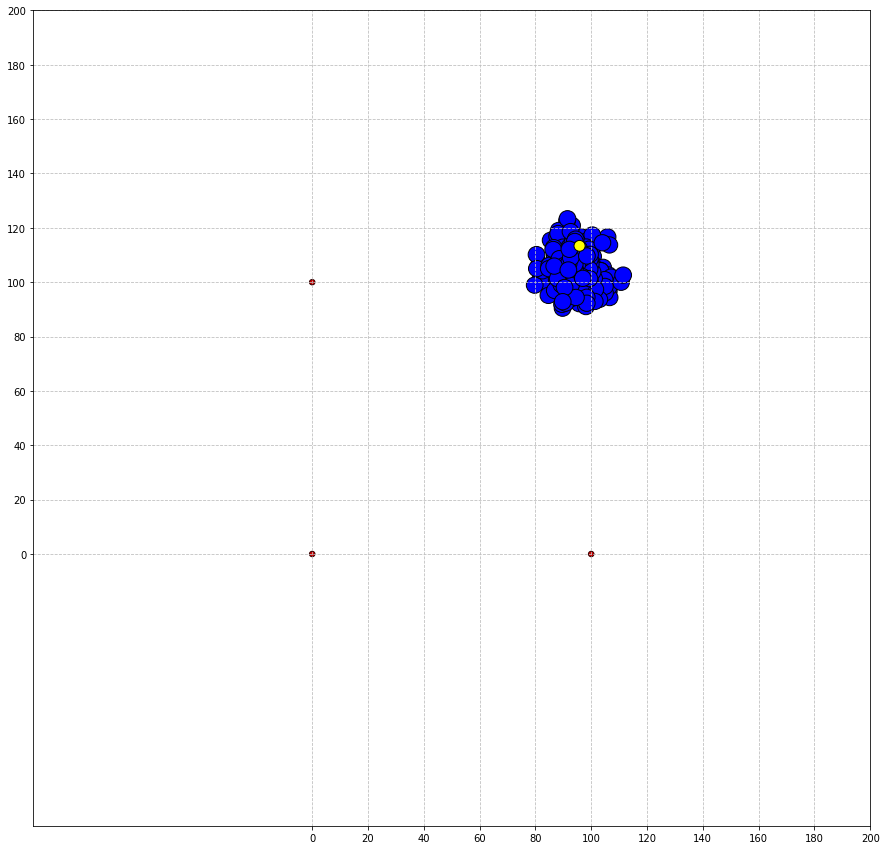

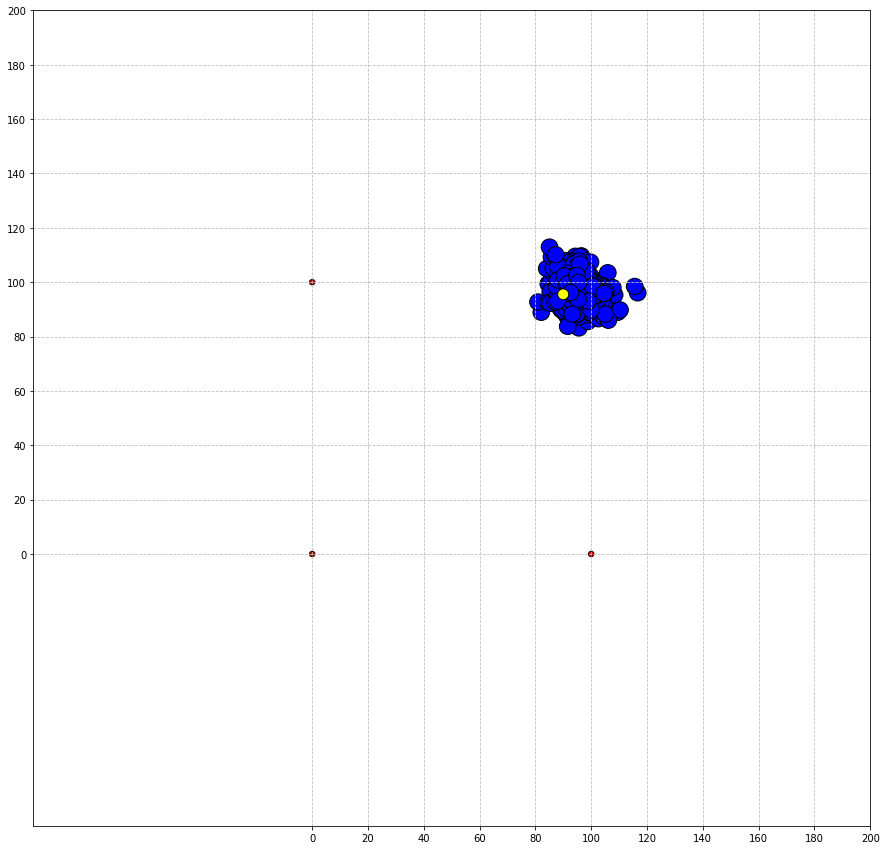

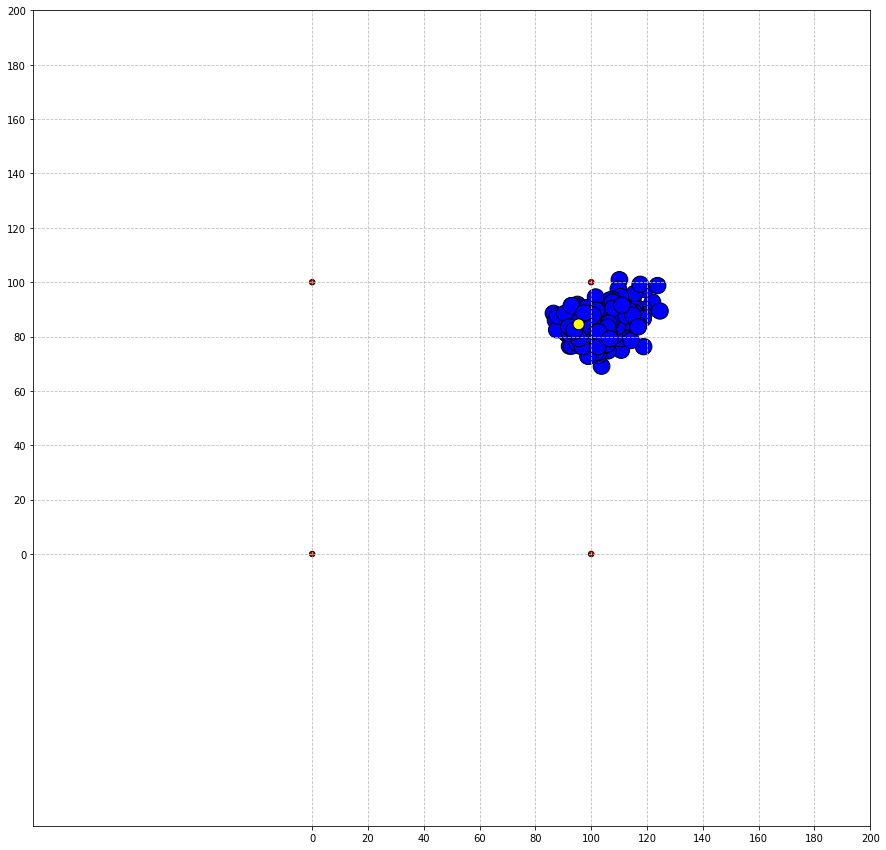

[95.4981424448332, 84.51389240566783, 5.50323416470052]


In [43]:
## --------
## TEST CASE #1:
## 
##1) Calling the particle_filter function with the following
##    motions and measurements should return a [x,y,orientation]
##    vector near [x=93.476 y=75.186 orient=5.2664], that is, the
##    robot's true location.
##
motions = [[2. * pi / 10, 20.] for row in range(8)]
measurements = [[4.746936, 3.859782, 3.045217, 2.045506],
                [3.510067, 2.916300, 2.146394, 1.598332],
                [2.972469, 2.407489, 1.588474, 1.611094],
                [1.906178, 1.193329, 0.619356, 0.807930],
                [1.352825, 0.662233, 0.144927, 0.799090],
                [0.856150, 0.214590, 5.651497, 1.062401],
                [0.194460, 5.660382, 4.761072, 2.471682],
                [5.717342, 4.736780, 3.909599, 2.342536]]
final  = particle_filter(motions, measurements)
print(final)

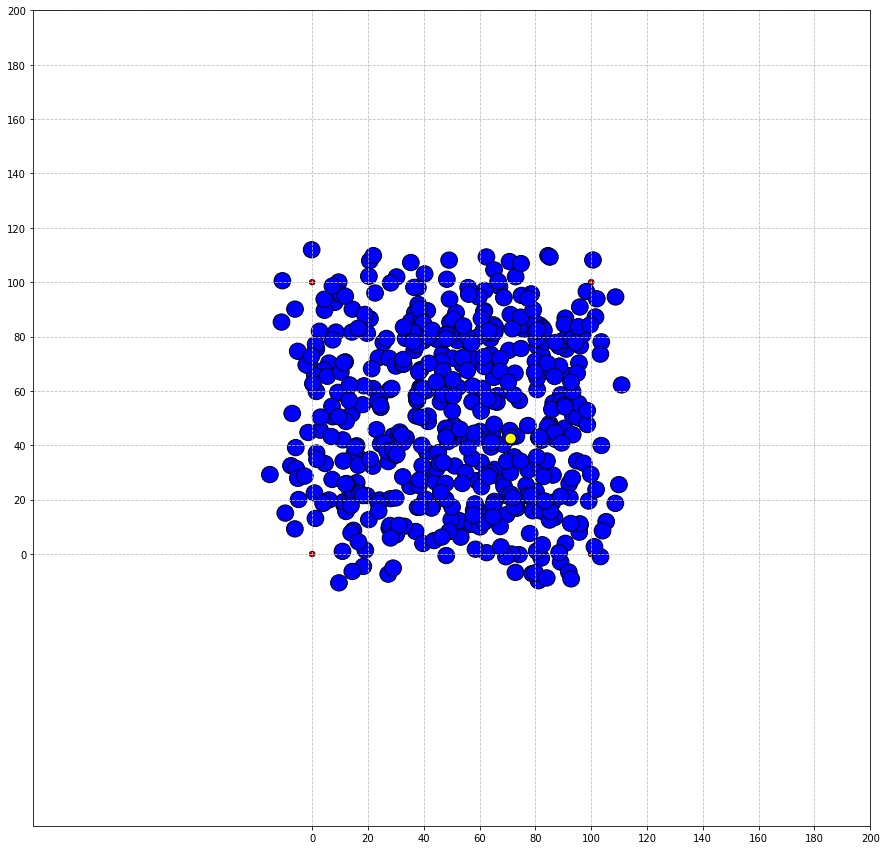

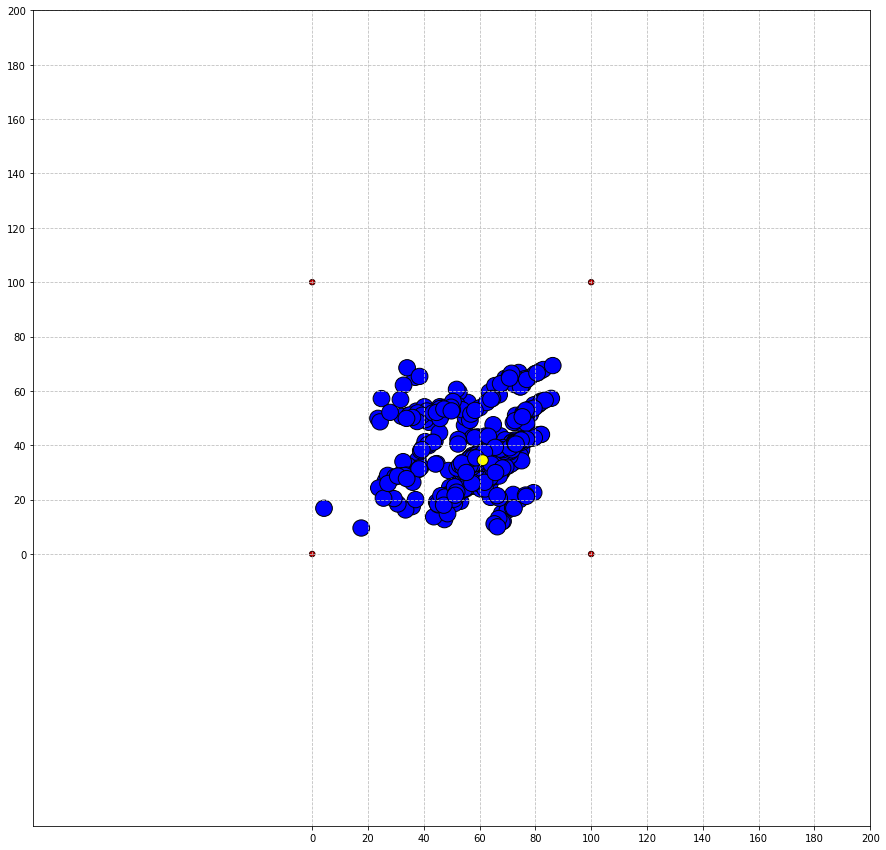

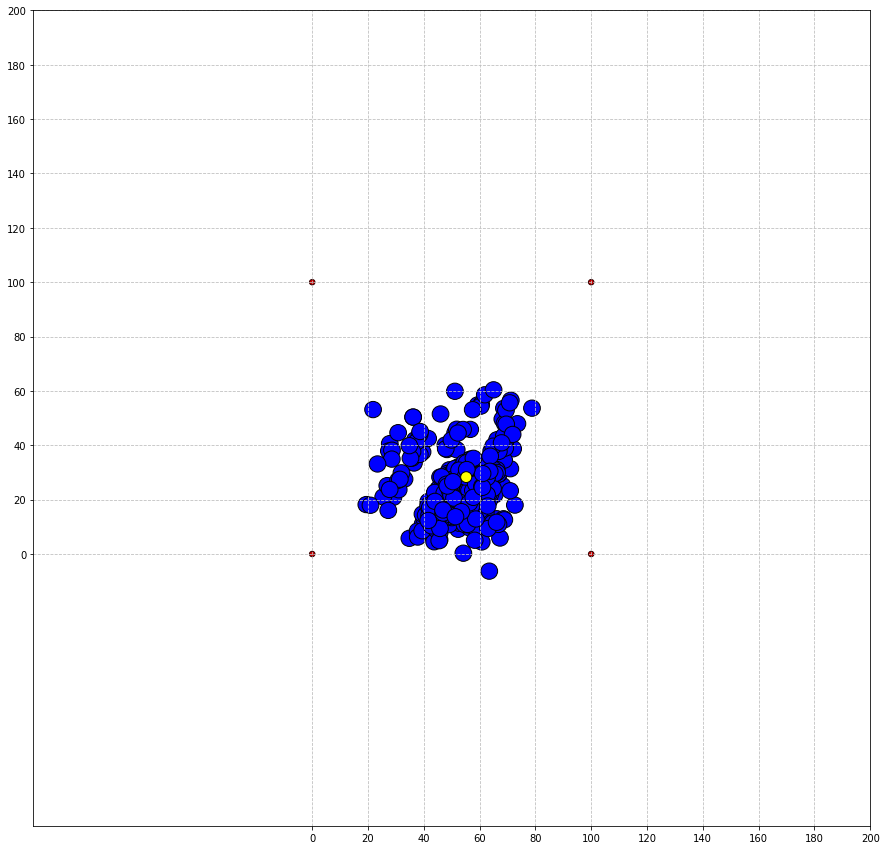

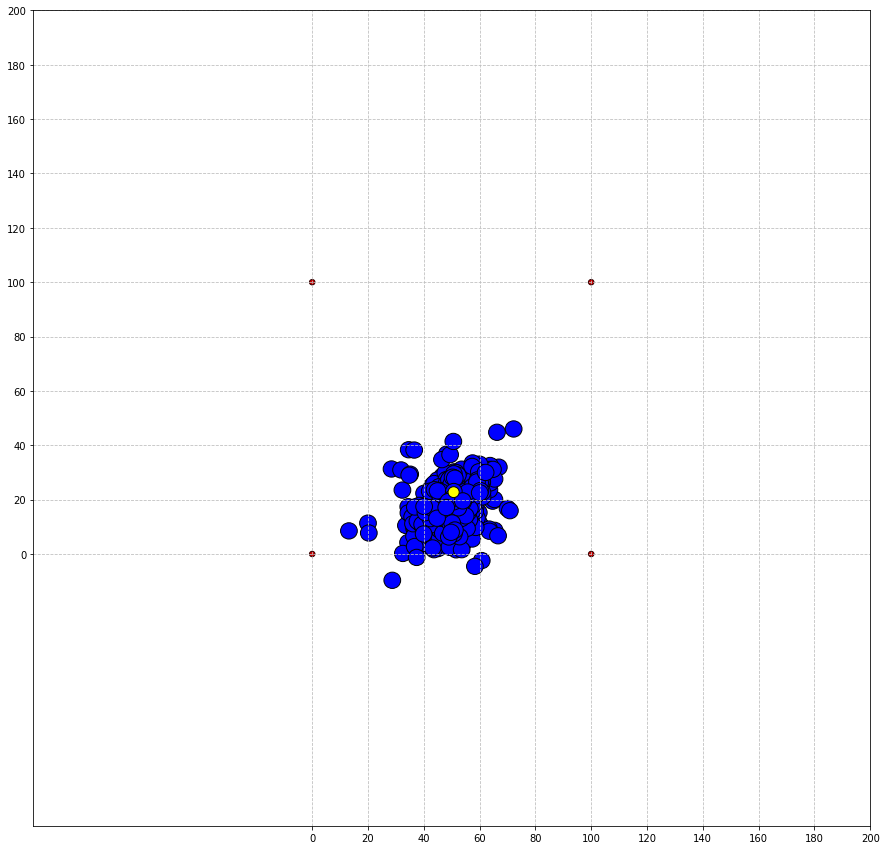

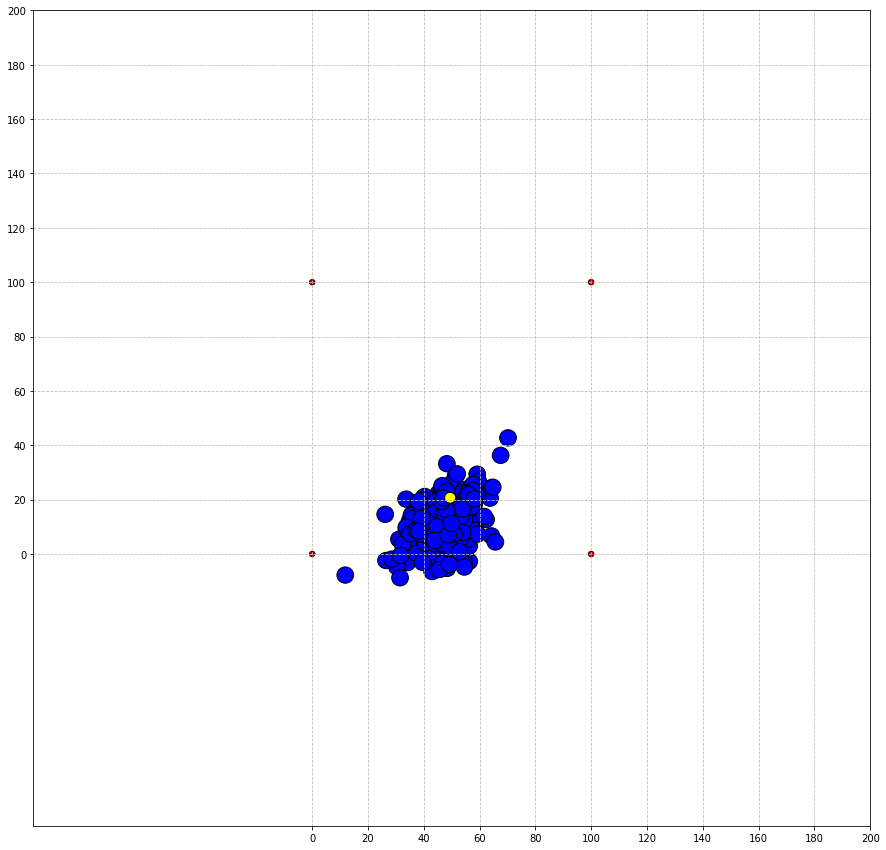

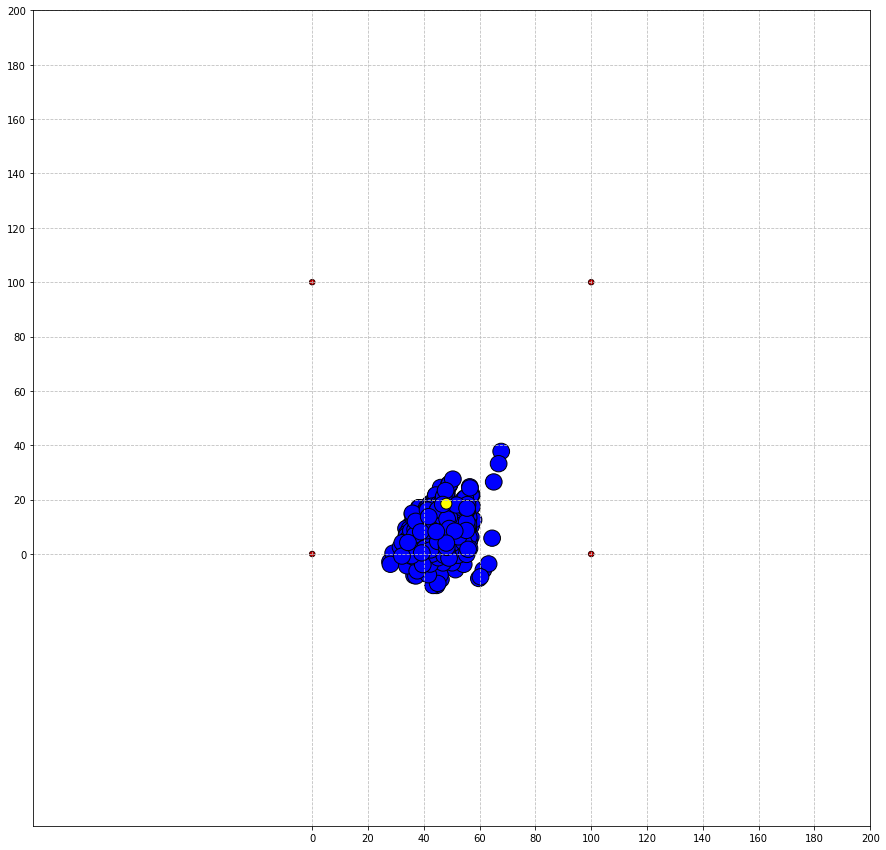

measurements = [[1.946636, 0.315287, 5.429686, 4.129659],
                [1.663921, -0.23911, 4.688427, 3.394641],
                [1.816248, -0.25229, 4.614341, 3.381470],
                [1.742459, -0.46022, 4.389395, 3.209093],
                [1.786371, -0.38328, 4.469357, 3.276391],
                [1.850532, -0.51455, 4.342635, 3.220900]]
Ground truth:     [x=48.263 y=20.429 theta=4.3161]
Particle filter:  [48.06472841854091, 18.519830277795958, 4.216106539913934]
Code check:       True


In [44]:
## --------
## TEST CASE #1:
##
## 2) You can generate your own test cases by generating
##    measurements using the generate_ground_truth function.
##    It will print the robot's last location when calling it.
##

number_of_iterations = 6
motions = [[2. * pi / 20, 12.] for row in range(number_of_iterations)]

x = generate_ground_truth(motions)
final_robot = x[0]
measurements = x[1]

estimated_position = particle_filter(motions, measurements)
print_measurements(measurements)
print('Ground truth:    ', final_robot) 
print('Particle filter: ', estimated_position)
print('Code check:      ', check_output(final_robot, estimated_position)) 